In [1]:
import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp

set_gpu()

Num GPUs Available:  1


# Load and Process Data

In [2]:
sub_type = 'TR'

In [3]:
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

# Single Subject Analysis 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from lda import train_lda, predict, eval_lda
import sVAE_utils as svae
import process_data as prd
import copy as cp

In [5]:
# Initialize variables
mod = 'sae'
sparsity = True
load = False
batch_size = 128
latent_dim = 3
epochs = 30
train_scale = 3
test_scale = 1
noise = True
n_train = 'gaussflat'
n_test = 'gauss'
feat_type =  'feat'
sub = 1
train_grp = 2

i_tot = 12
lat_tot = 10
acc_all = np.zeros([lat_tot,i_tot])
acc_clean = np.zeros([lat_tot,i_tot])
acc_noise = np.zeros([lat_tot,i_tot])

if n_train == 'flat':
    train_scale = 0
if n_test == 'flat':
    test_scale = 0

ind = (params[:,0] == sub) & (params[:,3] == train_grp)

enc_w = 0
dec_w = 0
clf_w = 0

## Single Subject Sparsity Test

In [7]:
noise_trans = np.transpose(acc_noise)
clean_trans = np.transpose(acc_clean)

In [6]:
import sVAE_utils as dl
# Split training and testing data
# x_train, x_test, p_train, p_test = train_test_split(raw[ind,:,:], params[ind,:], test_size = 0.33, stratify=params[ind,4])
# # # Initialize scaler
# scaler = MinMaxScaler(feature_range=(-1,1))
foldername = 'models' + '_' + str(train_grp)
if not os.path.exists(foldername):
    os.makedirs(foldername)
filename = foldername + '/sub_' + feat_type +'_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + n_train + '_' + str(train_scale) + '_'  + sub_type 
# if os.path.isfile(filename):
#     load = 'False'
# else:
#     load = 'True'
# Load saved data
with open(filename + str(sub) + '.p', 'rb') as f:
    scaler, svae_w, svae_enc_w, svae_dec_w, svae_clf_w, sae_w, sae_enc_w, sae_clf_w, cnn_w, cnn_enc_w, cnn_clf_w, w_svae, c_svae, \
        w_sae, c_sae, w_cnn, c_cnn, w_vcnn, c_vcnn, w, c, w_noise, c_noise, x_train, x_test, p_train, p_test = pickle.load(f) 
          
for latent_dim in range(1,9):
    # Check if training data exists
    if np.sum(ind):
        print('Running sub ' + str(sub) + ', model ' + str(train_grp))
        # Set folder and file names
        foldername = 'models' + '_' + str(train_grp)
        if not os.path.exists(foldername):
            os.makedirs(foldername)
        filename = foldername + '/sub_' + feat_type +'_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + n_train + '_' + str(train_scale) + '_'  + sub_type + 'sparse'
        # if os.path.isfile(filename):
        #     load = 'False'
        # else:
        #     load = 'True'
        # Load saved data
        if load:
            with open(filename + str(sub) + '.p', 'rb') as f:
                scaler, svae_w, svae_enc_w, svae_dec_w, svae_clf_w, sae_w, sae_enc_w, sae_clf_w, cnn_w, cnn_enc_w, cnn_clf_w, w_svae, c_svae, \
                    w_sae, c_sae, w_cnn, c_cnn, w_vcnn, c_vcnn, w, c, w_noise, c_noise, x_train, x_test, p_train, p_test = pickle.load(f)   
        # else:
        
        # Get ground truth
        y_train = p_train[:,4]
        y_test = p_test[:,4]

        # Add noise and index EMG data
        x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub, n_train, train_scale)
        x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub, n_test, test_scale)
        clean_size = int(np.size(x_test_clean,axis=0)/(np.size(x_test_clean,axis=1)+1))
        if not noise:
            x_train_noise = cp.deepcopy(x_train_clean)
            x_test_noise = cp.deepcopy(x_test_clean)

        # Extract features
        if feat_type == 'feat':
            x_train_noise_temp = np.transpose(prd.extract_feats(x_train_noise).reshape((x_train_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
            x_test_noise_temp = np.transpose(prd.extract_feats(x_test_noise).reshape((x_test_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
            x_train_clean_temp = np.transpose(prd.extract_feats(x_train_clean).reshape((x_train_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
            x_test_clean_temp = np.transpose(prd.extract_feats(x_test_clean).reshape((x_test_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
            if load:
                x_train_noise_vae = scaler.transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
            else:
                x_train_noise_vae = scaler.fit_transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
            
            x_train_vae = scaler.transform(x_train_clean_temp.reshape(x_train_clean_temp.shape[0]*x_train_clean_temp.shape[1],-1)).reshape(x_train_clean_temp.shape)
            x_test_vae = scaler.transform(x_test_noise_temp.reshape(x_test_noise_temp.shape[0]*x_test_noise_temp.shape[1],-1)).reshape(x_test_noise_temp.shape)
            x_test_clean_vae = scaler.transform(x_test_clean_temp.reshape(x_test_clean_temp.shape[0]*x_test_clean_temp.shape[1],-1)).reshape(x_test_clean_temp.shape)
            
            # Reshape for nonconvolutional SAE
            x_train_noise_sae = x_train_noise_vae.reshape(x_train_noise_vae.shape[0],-1)
            x_train_sae = x_train_vae.reshape(x_train_vae.shape[0],-1)
            x_test_sae = x_test_vae.reshape(x_test_vae.shape[0],-1)
            x_test_clean_sae = x_test_clean_vae.reshape(x_test_clean_vae.shape[0],-1)
        elif feat_type == 'raw':
            x_train_noise_temp = cp.deepcopy(x_train_noise)/5
            x_test_noise_temp = cp.deepcopy(x_test_noise)/5
            x_train_clean_temp = cp.deepcopy(x_train_clean)/5
            x_test_clean_temp = cp.deepcopy(x_test_clean)/5

        # Build VAE
        svae, svae_enc, svae_dec, svae_clf = dl.build_svae(latent_dim, y_train_clean.shape[1], input_type=feat_type, sparse=sparsity)
        sae, sae_enc, sae_clf = dl.build_sae(latent_dim, y_train_clean.shape[1], input_type=feat_type, sparse=sparsity)
        cnn, cnn_enc, cnn_clf = dl.build_cnn(latent_dim, y_train_clean.shape[1], input_type=feat_type, sparse=sparsity)
        vcnn, vcnn_enc, vcnn_clf = dl.build_vcnn(latent_dim, y_train_clean.shape[1], input_type=feat_type, sparse=sparsity)

        # Fit sVAE and get weights
        if not load:
            svae.fit(x_train_noise_vae, [x_train_vae,y_train_clean],epochs=epochs,batch_size=batch_size)
            svae_w = svae.get_weights()
            svae_enc_w = svae_enc.get_weights()
            svae_dec_w = svae_dec.get_weights()
            svae_clf_w = svae_clf.get_weights()
            
            sae.fit(x_train_noise_sae, y_train_clean,epochs=epochs,batch_size=batch_size)
            sae_w = sae.get_weights()
            sae_enc_w = sae_enc.get_weights()
            sae_clf_w = sae_clf.get_weights()

            cnn.fit(x_train_noise_vae, y_train_clean,epochs=epochs,batch_size=batch_size)
            cnn_w = cnn.get_weights()
            cnn_enc_w = cnn_enc.get_weights()
            cnn_clf_w = cnn_clf.get_weights()

            vcnn.fit(x_train_noise_vae, y_train_clean,epochs=epochs,batch_size=batch_size)
            vcnn_w = vcnn.get_weights()
            vcnn_enc_w = vcnn_enc.get_weights()
            vcnn_clf_w = vcnn_clf.get_weights()

        # Load and set weights
        if load:
            svae.set_weights(svae_w)
            svae_enc.set_weights(svae_enc_w)
            svae_dec.set_weights(svae_dec_w)
            svae_clf.set_weights(svae_clf_w)

            sae.set_weights(sae_w)
            sae_enc.set_weights(sae_enc_w)
            sae_clf.set_weights(sae_clf_w)

            cnn.set_weights(cnn_w)
            cnn_enc.set_weights(cnn_enc_w)
            cnn_clf.set_weights(cnn_clf_w)

            vcnn.set_weights(vcnn_w)
            vcnn_enc.set_weights(vcnn_enc_w)
            vcnn_clf.set_weights(vcnn_clf_w)

        i = 0
        # Test full VAE
        y_pred, acc_all[latent_dim,i] = dl.eval_vae(svae, x_test_vae, y_test_clean)
        _, acc_noise[latent_dim,i] = dl.eval_vae(svae,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
        _, acc_clean[latent_dim,i] = dl.eval_vae(svae,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
        i += 1

        y_pred, acc_all[latent_dim,i] = dl.eval_vae(sae, x_test_sae, y_test_clean)
        _, acc_noise[latent_dim,i] = dl.eval_vae(sae,x_test_sae[clean_size:,...], y_test_clean[clean_size:,:])
        _, acc_clean[latent_dim,i] = dl.eval_vae(sae,x_test_sae[:clean_size,...], y_test_clean[:clean_size,:])
        i += 1

        y_pred, acc_all[latent_dim,i] = dl.eval_vae(cnn, x_test_vae, y_test_clean)
        _, acc_noise[latent_dim,i] = dl.eval_vae(cnn,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
        _, acc_clean[latent_dim,i] = dl.eval_vae(cnn,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
        i += 1

        y_pred, acc_all[latent_dim,i] = dl.eval_vae(vcnn, x_test_vae, y_test_clean)
        _, acc_noise[latent_dim,i] = dl.eval_vae(vcnn,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
        _, acc_clean[latent_dim,i] = dl.eval_vae(vcnn,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
        i += 1

        # Test encoder-LDA combo
        _, _, x_train_svae = svae_enc.predict(x_train_noise_vae)
        _,_, x_test_svae = svae_enc.predict(x_test_vae)
        x_train_sae = sae_enc.predict(x_train_noise_sae)
        x_test_sae = sae_enc.predict(x_test_sae)
        x_train_cnn = cnn_enc.predict(x_train_noise_vae)
        x_test_cnn = cnn_enc.predict(x_test_vae)
        _, _, x_train_vcnn = vcnn_enc.predict(x_train_noise_vae)
        _, _, x_test_vcnn = vcnn_enc.predict(x_test_vae)

        y_train_aligned = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
        y_test_aligned = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
        w_svae, c_svae = train_lda(x_train_svae,y_train_aligned)
        acc_all[latent_dim,i] = eval_lda(w_svae, c_svae, x_test_svae, y_test_aligned)
        acc_noise[latent_dim,i] = eval_lda(w_svae, c_svae, x_test_svae[clean_size:,:], y_test_aligned[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w_svae, c_svae, x_test_svae[:clean_size,:], y_test_aligned[:clean_size,:])
        i += 1

        w_sae, c_sae = train_lda(x_train_sae,y_train_aligned)
        acc_all[latent_dim,i] = eval_lda(w_sae, c_sae, x_test_sae, y_test_aligned)
        acc_noise[latent_dim,i] = eval_lda(w_sae, c_sae, x_test_sae[clean_size:,:], y_test_aligned[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w_sae, c_sae, x_test_sae[:clean_size,:], y_test_aligned[:clean_size,:])
        i += 1

        w_cnn, c_cnn = train_lda(x_train_cnn,y_train_aligned)
        acc_all[latent_dim,i] = eval_lda(w_cnn, c_cnn, x_test_cnn, y_test_aligned)
        acc_noise[latent_dim,i] = eval_lda(w_cnn, c_cnn, x_test_cnn[clean_size:,:], y_test_aligned[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w_cnn, c_cnn, x_test_cnn[:clean_size,:], y_test_aligned[:clean_size,:])
        i += 1

        w_vcnn, c_vcnn = train_lda(x_train_vcnn,y_train_aligned)
        acc_all[latent_dim,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn, y_test_aligned)
        acc_noise[latent_dim,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn[clean_size:,:], y_test_aligned[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn[:clean_size,:], y_test_aligned[:clean_size,:])
        i += 1

        # Baseline LDA
        x_train_lda = prd.extract_feats(x_train)
        x_test_lda = prd.extract_feats(x_test_noise)
        y_train_lda = y_train[...,np.newaxis] - 1
        y_test_lda = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
        w,c = train_lda(x_train_lda,y_train_lda)
        acc_all[latent_dim,i] = eval_lda(w, c, x_test_lda, y_test_lda)
        acc_noise[latent_dim,i] = eval_lda(w, c, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w, c, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])
        i += 1

        # LDA trained with corrupted data
        x_train_lda2 = prd.extract_feats(x_train_noise)
        y_train_lda2 = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
        w_noise,c_noise = train_lda(x_train_lda2,y_train_lda2)
        acc_all[latent_dim,i] = eval_lda(w_noise, c_noise, x_test_lda, y_test_lda)
        acc_noise[latent_dim,i] = eval_lda(w_noise, c_noise, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
        acc_clean[latent_dim,i] = eval_lda(w_noise, c_noise, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])
        i += 1

        # QDA trained with clean data
        qda = QDA()
        qda.fit(x_train_lda, np.squeeze(y_train_lda))
        acc_all[latent_dim,i] = qda.score(x_test_lda,np.squeeze(y_test_lda))
        acc_noise[latent_dim,i] = qda.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
        acc_clean[latent_dim,i] = qda.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))
        i += 1

        # QDA trained with corrupted data
        qda_noise = QDA()
        qda_noise.fit(x_train_lda2, np.squeeze(y_train_lda2))
        acc_all[latent_dim,i] = qda_noise.score(x_test_lda,np.squeeze(y_test_lda))
        acc_noise[latent_dim,i] = qda_noise.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
        acc_clean[latent_dim,i] = qda_noise.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))

        # Pickle variables
        with open(filename + str(sub) + '.p', 'wb') as f:
            pickle.dump([scaler, svae_w, svae_enc_w, svae_dec_w, svae_clf_w, sae_w, sae_enc_w, sae_clf_w, cnn_w, cnn_enc_w, cnn_clf_w, \
                w_svae, c_svae, w_sae, c_sae, w_cnn, c_cnn, w_vcnn, c_vcnn, w, c, w_noise, c_noise, x_train, x_test, p_train, p_test],f)

print('----------------DONE----------------')

] - 1s 62us/sample - loss: 1.2902
Epoch 3/30
16415/16415 [==============================] - 1s 72us/sample - loss: 1.0759
Epoch 4/30
16415/16415 [==============================] - 1s 72us/sample - loss: 0.8819
Epoch 5/30
16415/16415 [==============================] - 1s 65us/sample - loss: 0.7232
Epoch 6/30
16415/16415 [==============================] - 1s 72us/sample - loss: 0.6433
Epoch 7/30
16415/16415 [==============================] - 1s 63us/sample - loss: 0.5926
Epoch 8/30
16415/16415 [==============================] - 1s 64us/sample - loss: 0.5514
Epoch 9/30
16415/16415 [==============================] - 1s 63us/sample - loss: 0.5251
Epoch 10/30
16415/16415 [==============================] - 1s 66us/sample - loss: 0.5018
Epoch 11/30
16415/16415 [==============================] - 1s 65us/sample - loss: 0.4742
Epoch 12/30
16415/16415 [==============================] - 1s 64us/sample - loss: 0.4691
Epoch 13/30
16415/16415 [==============================] - 1s 65us/sample - loss: 0

In [6]:
import sVAE_utils as dl

# Check if training data exists
if np.sum(ind):
    print('Running sub ' + str(sub) + ', model ' + str(train_grp))
    # Set folder and file names
    foldername = 'models' + '_' + str(train_grp)
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    filename = foldername + '/sub_' + feat_type +'_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + n_train + '_' + str(train_scale) + '_'  + sub_type

    # Load saved data
    if load:
        with open(filename + str(sub) + '.p', 'rb') as f:
            scaler, svae_w, svae_enc_w, svae_dec_w, svae_clf_w, sae_w, sae_enc_w, sae_clf_w, cnn_w, cnn_enc_w, cnn_clf_w, w_svae, c_svae, \
                w_sae, c_sae, w_cnn, c_cnn, w_vcnn, c_vcnn, w, c, w_noise, c_noise, x_train, x_test, p_train, p_test = pickle.load(f)   
    else:
        # Split training and testing data
        x_train, x_test, p_train, p_test = train_test_split(raw[ind,:,:], params[ind,:], test_size = 0.33, stratify=params[ind,4])
        # # Initialize scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
    
    # Get ground truth
    y_train = p_train[:,4]
    y_test = p_test[:,4]

    # Add noise and index EMG data
    x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub, n_train, train_scale)
    x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub, n_test, test_scale)
    clean_size = int(np.size(x_test_clean,axis=0)/(np.size(x_test_clean,axis=1)+1))
    if not noise:
        x_train_noise = cp.deepcopy(x_train_clean)
        x_test_noise = cp.deepcopy(x_test_clean)

    # Extract features
    if feat_type == 'feat':
        x_train_noise_temp = np.transpose(prd.extract_feats(x_train_noise).reshape((x_train_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_test_noise_temp = np.transpose(prd.extract_feats(x_test_noise).reshape((x_test_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_train_clean_temp = np.transpose(prd.extract_feats(x_train_clean).reshape((x_train_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_test_clean_temp = np.transpose(prd.extract_feats(x_test_clean).reshape((x_test_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        if load:
            x_train_noise_vae = scaler.transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
        else:
            x_train_noise_vae = scaler.fit_transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
        
        x_train_vae = scaler.transform(x_train_clean_temp.reshape(x_train_clean_temp.shape[0]*x_train_clean_temp.shape[1],-1)).reshape(x_train_clean_temp.shape)
        x_test_vae = scaler.transform(x_test_noise_temp.reshape(x_test_noise_temp.shape[0]*x_test_noise_temp.shape[1],-1)).reshape(x_test_noise_temp.shape)
        x_test_clean_vae = scaler.transform(x_test_clean_temp.reshape(x_test_clean_temp.shape[0]*x_test_clean_temp.shape[1],-1)).reshape(x_test_clean_temp.shape)
        
        # Reshape for nonconvolutional SAE
        x_train_noise_sae = x_train_noise_vae.reshape(x_train_noise_vae.shape[0],-1)
        x_train_sae = x_train_vae.reshape(x_train_vae.shape[0],-1)
        x_test_sae = x_test_vae.reshape(x_test_vae.shape[0],-1)
        x_test_clean_sae = x_test_clean_vae.reshape(x_test_clean_vae.shape[0],-1)
    elif feat_type == 'raw':
        x_train_noise_temp = cp.deepcopy(x_train_noise)/5
        x_test_noise_temp = cp.deepcopy(x_test_noise)/5
        x_train_clean_temp = cp.deepcopy(x_train_clean)/5
        x_test_clean_temp = cp.deepcopy(x_test_clean)/5

    # Build VAE
    svae, svae_enc, svae_dec, svae_clf = dl.build_svae(latent_dim, y_train_clean.shape[1], input_type=feat_type)
    sae, sae_enc, sae_clf = dl.build_sae(latent_dim, y_train_clean.shape[1], input_type=feat_type)
    cnn, cnn_enc, cnn_clf = dl.build_cnn(latent_dim, y_train_clean.shape[1], input_type=feat_type)
    # vcnn, vcnn_enc, vcnn_clf = dl.build_vcnn(latent_dim, y_train_clean.shape[1], input_type=feat_type)
    vcnn, vcnn_enc, vcnn_dec, vcnn_clf = dl.build_svae(latent_dim, y_train_clean.shape[1], input_type=feat_type, sparse='False')


    # Fit sVAE and get weights
    if not load:
        svae.fit(x_train_noise_vae, [x_train_vae,y_train_clean],epochs=epochs,batch_size=batch_size)
        svae_w = svae.get_weights()
        svae_enc_w = svae_enc.get_weights()
        svae_dec_w = svae_dec.get_weights()
        svae_clf_w = svae_clf.get_weights()
        
        sae.fit(x_train_noise_sae, y_train_clean,epochs=epochs,batch_size=batch_size)
        sae_w = sae.get_weights()
        sae_enc_w = sae_enc.get_weights()
        sae_clf_w = sae_clf.get_weights()

        cnn.fit(x_train_noise_vae, y_train_clean,epochs=epochs,batch_size=batch_size)
        cnn_w = cnn.get_weights()
        cnn_enc_w = cnn_enc.get_weights()
        cnn_clf_w = cnn_clf.get_weights()

        # vcnn.fit(x_train_noise_vae, y_train_clean,epochs=epochs,batch_size=batch_size)
        # vcnn_w = vcnn.get_weights()
        # vcnn_enc_w = vcnn_enc.get_weights()
        # vcnn_clf_w = vcnn_clf.get_weights()

        vcnn.fit(x_train_noise_vae, [x_train_vae,y_train_clean],epochs=epochs,batch_size=batch_size)
        vcnn_w = vcnn.get_weights()
        vcnn_enc_w = vcnn_enc.get_weights()
        vcnn_clf_w = vcnn_clf.get_weights()

    # Load and set weights
    if load:
        svae.set_weights(svae_w)
        svae_enc.set_weights(svae_enc_w)
        svae_dec.set_weights(svae_dec_w)
        svae_clf.set_weights(svae_clf_w)

        sae.set_weights(sae_w)
        sae_enc.set_weights(sae_enc_w)
        sae_clf.set_weights(sae_clf_w)

        cnn.set_weights(cnn_w)
        cnn_enc.set_weights(cnn_enc_w)
        cnn_clf.set_weights(cnn_clf_w)

        vcnn.set_weights(vcnn_w)
        vcnn_enc.set_weights(vcnn_enc_w)
        vcnn_clf.set_weights(vcnn_clf_w)

    i = 0
    # Test full VAE
    y_pred, acc_all[0,i] = dl.eval_vae(svae, x_test_vae, y_test_clean)
    _, acc_noise[0,i] = dl.eval_vae(svae,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
    _, acc_clean[0,i] = dl.eval_vae(svae,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
    i += 1

    y_pred, acc_all[0,i] = dl.eval_vae(sae, x_test_sae, y_test_clean)
    _, acc_noise[0,i] = dl.eval_vae(sae,x_test_sae[clean_size:,...], y_test_clean[clean_size:,:])
    _, acc_clean[0,i] = dl.eval_vae(sae,x_test_sae[:clean_size,...], y_test_clean[:clean_size,:])
    i += 1

    y_pred, acc_all[0,i] = dl.eval_vae(cnn, x_test_vae, y_test_clean)
    _, acc_noise[0,i] = dl.eval_vae(cnn,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
    _, acc_clean[0,i] = dl.eval_vae(cnn,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
    i += 1

    y_pred, acc_all[0,i] = dl.eval_vae(vcnn, x_test_vae, y_test_clean)
    _, acc_noise[0,i] = dl.eval_vae(vcnn,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
    _, acc_clean[0,i] = dl.eval_vae(vcnn,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])
    i += 1

    # Test encoder-LDA combo
    _, _, x_train_svae = svae_enc.predict(x_train_noise_vae)
    _,_, x_test_svae = svae_enc.predict(x_test_vae)
    x_train_sae = sae_enc.predict(x_train_noise_sae)
    x_test_sae = sae_enc.predict(x_test_sae)
    x_train_cnn = cnn_enc.predict(x_train_noise_vae)
    x_test_cnn = cnn_enc.predict(x_test_vae)
    _, _, x_train_vcnn = vcnn_enc.predict(x_train_noise_vae)
    _, _, x_test_vcnn = vcnn_enc.predict(x_test_vae)

    y_train_aligned = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
    y_test_aligned = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
    w_svae, c_svae = train_lda(x_train_svae,y_train_aligned)
    acc_all[0,i] = eval_lda(w_svae, c_svae, x_test_svae, y_test_aligned)
    acc_noise[0,i] = eval_lda(w_svae, c_svae, x_test_svae[clean_size:,:], y_test_aligned[clean_size:,:])
    acc_clean[0,i] = eval_lda(w_svae, c_svae, x_test_svae[:clean_size,:], y_test_aligned[:clean_size,:])
    i += 1

    w_sae, c_sae = train_lda(x_train_sae,y_train_aligned)
    acc_all[0,i] = eval_lda(w_sae, c_sae, x_test_sae, y_test_aligned)
    acc_noise[0,i] = eval_lda(w_sae, c_sae, x_test_sae[clean_size:,:], y_test_aligned[clean_size:,:])
    acc_clean[0,i] = eval_lda(w_sae, c_sae, x_test_sae[:clean_size,:], y_test_aligned[:clean_size,:])
    i += 1

    w_cnn, c_cnn = train_lda(x_train_cnn,y_train_aligned)
    acc_all[0,i] = eval_lda(w_cnn, c_cnn, x_test_cnn, y_test_aligned)
    acc_noise[0,i] = eval_lda(w_cnn, c_cnn, x_test_cnn[clean_size:,:], y_test_aligned[clean_size:,:])
    acc_clean[0,i] = eval_lda(w_cnn, c_cnn, x_test_cnn[:clean_size,:], y_test_aligned[:clean_size,:])
    i += 1

    w_vcnn, c_vcnn = train_lda(x_train_vcnn,y_train_aligned)
    acc_all[0,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn, y_test_aligned)
    acc_noise[0,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn[clean_size:,:], y_test_aligned[clean_size:,:])
    acc_clean[0,i] = eval_lda(w_vcnn, c_vcnn, x_test_vcnn[:clean_size,:], y_test_aligned[:clean_size,:])
    i += 1

    # Baseline LDA
    x_train_lda = prd.extract_feats(x_train)
    x_test_lda = prd.extract_feats(x_test_noise)
    y_train_lda = y_train[...,np.newaxis] - 1
    y_test_lda = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
    w,c = train_lda(x_train_lda,y_train_lda)
    acc_all[0,i] = eval_lda(w, c, x_test_lda, y_test_lda)
    acc_noise[0,i] = eval_lda(w, c, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
    acc_clean[0,i] = eval_lda(w, c, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])
    i += 1

    # LDA trained with corrupted data
    x_train_lda2 = prd.extract_feats(x_train_noise)
    y_train_lda2 = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
    w_noise,c_noise = train_lda(x_train_lda2,y_train_lda2)
    acc_all[0,i] = eval_lda(w_noise, c_noise, x_test_lda, y_test_lda)
    acc_noise[0,i] = eval_lda(w_noise, c_noise, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
    acc_clean[0,i] = eval_lda(w_noise, c_noise, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])
    i += 1

    # QDA trained with clean data
    qda = QDA()
    qda.fit(x_train_lda, np.squeeze(y_train_lda))
    acc_all[0,i] = qda.score(x_test_lda,np.squeeze(y_test_lda))
    acc_noise[0,i] = qda.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
    acc_clean[0,i] = qda.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))
    i += 1

    # QDA trained with corrupted data
    qda_noise = QDA()
    qda_noise.fit(x_train_lda2, np.squeeze(y_train_lda2))
    acc_all[0,i] = qda_noise.score(x_test_lda,np.squeeze(y_test_lda))
    acc_noise[0,i] = qda_noise.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
    acc_clean[0,i] = qda_noise.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))

    # Pickle variables
    with open(filename + str(sub) + '.p', 'wb') as f:
        pickle.dump([scaler, svae_w, svae_enc_w, svae_dec_w, svae_clf_w, sae_w, sae_enc_w, sae_clf_w, cnn_w, cnn_enc_w, cnn_clf_w, \
            w_svae, c_svae, w_sae, c_sae, w_cnn, c_cnn, w_vcnn, c_vcnn, w, c, w_noise, c_noise, x_train, x_test, p_train, p_test],f)

print('----------------DONE----------------')

 97us/sample - loss: 0.3053 - decoder_loss: 0.1222 - clf_loss: 0.1777
Epoch 18/50
16415/16415 [==============================] - 2s 99us/sample - loss: 0.2896 - decoder_loss: 0.1204 - clf_loss: 0.1644
Epoch 19/50
16415/16415 [==============================] - 2s 97us/sample - loss: 0.2815 - decoder_loss: 0.1186 - clf_loss: 0.1590
Epoch 20/50
16415/16415 [==============================] - 2s 97us/sample - loss: 0.2783 - decoder_loss: 0.1166 - clf_loss: 0.1572
Epoch 21/50
16415/16415 [==============================] - 2s 96us/sample - loss: 0.2744 - decoder_loss: 0.1143 - clf_loss: 0.1550
Epoch 22/50
16415/16415 [==============================] - 2s 95us/sample - loss: 0.2640 - decoder_loss: 0.1129 - clf_loss: 0.1471
Epoch 23/50
16415/16415 [==============================] - 2s 100us/sample - loss: 0.2610 - decoder_loss: 0.1115 - clf_loss: 0.1473
Epoch 24/50
16415/16415 [==============================] - 2s 101us/sample - loss: 0.2575 - decoder_loss: 0.1102 - clf_loss: 0.1428
Epoch 25/50

## Single Subject Single Autoencoder Analysis

In [15]:
# Check if training data exists
if np.sum(ind):
    print('Running sub ' + str(sub) + ', model ' + str(train_grp))
    # Set folder and file names
    foldername = 'models' + '_' + str(train_grp)
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    filename = foldername + '/sub_' + mod + '_' + feat_type +'_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + n_train + '_' + str(train_scale) + '_'  + sub_type

    # Load saved data
    if load:
        with open(filename + str(sub) + '.p', 'rb') as f:
            scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_noise, c_noise, w_aligned, c_aligned, x_train, x_test, p_train, p_test = pickle.load(f)   
    else:
        # Split training and testing data
        x_train, x_test, p_train, p_test = train_test_split(raw[ind,:,:], params[ind,:], test_size = 0.33, stratify=params[ind,4])
        # # Initialize scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
    
    # Get ground truth
    y_train = p_train[:,4]
    y_test = p_test[:,4]

    # Add noise and index EMG data
    x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub, n_train, train_scale)
    x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub, n_test, test_scale)
    clean_size = int(np.size(x_test_clean,axis=0)/(np.size(x_test_clean,axis=1)+1))
    if not noise:
        x_train_noise = cp.deepcopy(x_train_clean)
        x_test_noise = cp.deepcopy(x_test_clean)

    # Extract features
    if feat_type == 'feat':
        x_train_noise_temp = np.transpose(prd.extract_feats(x_train_noise).reshape((x_train_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_test_noise_temp = np.transpose(prd.extract_feats(x_test_noise).reshape((x_test_noise.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_train_clean_temp = np.transpose(prd.extract_feats(x_train_clean).reshape((x_train_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        x_test_clean_temp = np.transpose(prd.extract_feats(x_test_clean).reshape((x_test_clean.shape[0],4,-1)),(0,2,1))[...,np.newaxis]
        if load:
            x_train_noise_vae = scaler.transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
        else:
            x_train_noise_vae = scaler.fit_transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0]*x_train_noise_temp.shape[1],-1)).reshape(x_train_noise_temp.shape)
            x_train_vae = scaler.transform(x_train_clean_temp.reshape(x_train_clean_temp.shape[0]*x_train_clean_temp.shape[1],-1)).reshape(x_train_clean_temp.shape)
            x_test_vae = scaler.transform(x_test_noise_temp.reshape(x_test_noise_temp.shape[0]*x_test_noise_temp.shape[1],-1)).reshape(x_test_noise_temp.shape)
            x_test_clean_vae = scaler.transform(x_test_clean_temp.reshape(x_test_clean_temp.shape[0]*x_test_clean_temp.shape[1],-1)).reshape(x_test_clean_temp.shape)
        if mod == 'sae':
            x_train_noise_vae = x_train_noise_vae.reshape(x_train_noise_vae.shape[0],-1)
            x_train_vae = x_train_vae.reshape(x_train_vae.shape[0],-1)
            x_test_vae = x_test_vae.reshape(x_test_vae.shape[0],-1)
            x_test_clean_vae = x_test_clean_vae.reshape(x_test_clean_vae.shape[0],-1)

    elif feat_type == 'raw':
        x_train_noise_temp = cp.deepcopy(x_train_noise)/5
        x_test_noise_temp = cp.deepcopy(x_test_noise)/5
        x_train_clean_temp = cp.deepcopy(x_train_clean)/5
        x_test_clean_temp = cp.deepcopy(x_test_clean)/5

    # Build VAE
    if mod == 'svae':
        vae, encoder, decoder,clf = svae.build_svae(latent_dim, y_train_clean.shape[1], input_type=feat_type)
        y_fit = [x_train_vae,y_train_clean]
    elif mod == 'vae':
        vae, encoder, decoder = svae.build_vae(latent_dim, input_type=feat_type)
        y_fit = x_train_vae
    elif mod == 'sae':
        vae, encoder, clf = svae.build_sae(latent_dim, y_train_clean.shape[1], input_type=feat_type)
        y_fit = y_train_clean
    elif mod == 'cnn':
        vae, encoder, clf = svae.build_cnn(latent_dim, y_train_clean.shape[1], input_type=feat_type)
        y_fit = y_train_clean

    # Fit sVAE and get weights
    if not load:
        vae.fit(x_train_noise_vae, y_fit,epochs=epochs,batch_size=batch_size)
        vae_w = vae.get_weights()
        enc_w = encoder.get_weights()
        if mod != 'sae' and mod != 'cnn':
            dec_w = decoder.get_weights()
        if mod != 'vae':
            clf_w = clf.get_weights()

    # Load and set weights
    if load:
        vae.set_weights(vae_w)
        encoder.set_weights(enc_w)
        if mod != 'sae' and mod != 'cnn':
            decoder.set_weights(dec_w)
        if mod != 'vae':
            clf.set_weights(clf_w)

    # Test full VAE
    y_pred, acc_all[0,0] = svae.eval_vae(vae, x_test_vae, y_test_clean)
    _, acc_noise[0,0] = svae.eval_vae(vae,x_test_vae[clean_size:,...], y_test_clean[clean_size:,:])
    _, acc_clean[0,0] = svae.eval_vae(vae,x_test_vae[:clean_size,...], y_test_clean[:clean_size,:])

    # Test encoder-LDA combo
    if mod != 'sae' and mod != 'cnn':
        _, _, x_train_aligned = encoder.predict(x_train_noise_vae)
        _,_, x_test_aligned = encoder.predict(x_test_vae)
    else:
        x_train_aligned = encoder.predict(x_train_noise_vae)
        x_test_aligned = encoder.predict(x_test_vae)

    y_train_aligned = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
    y_test_aligned = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
    w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)
    acc_all[0,1] = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)
    acc_noise[0,1] = eval_lda(w_aligned, c_aligned, x_test_aligned[clean_size:,:], y_test_aligned[clean_size:,:])
    acc_clean[0,1] = eval_lda(w_aligned, c_aligned, x_test_aligned[:clean_size,:], y_test_aligned[:clean_size,:])

    # Baseline LDA
    x_train_lda = prd.extract_feats(x_train)
    x_test_lda = prd.extract_feats(x_test_noise)
    y_train_lda = y_train[...,np.newaxis] - 1
    y_test_lda = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
    w,c = train_lda(x_train_lda,y_train_lda)
    acc_all[0,2] = eval_lda(w, c, x_test_lda, y_test_lda)
    acc_noise[0,2] = eval_lda(w, c, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
    acc_clean[0,2] = eval_lda(w, c, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])

    # QDA trained with clean data
    qda = QDA()
    qda.fit(x_train_lda, np.squeeze(y_train_lda))
    acc_all[0,4] = qda.score(x_test_lda,np.squeeze(y_test_lda))
    acc_noise[0,4] = qda.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
    acc_clean[0,4] = qda.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))

    # LDA trained with corrupted data
    x_train_lda2 = prd.extract_feats(x_train_noise)
    y_train_lda2 = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
    w_noise,c_noise = train_lda(x_train_lda2,y_train_lda2)
    acc_all[0,3] = eval_lda(w_noise, c_noise, x_test_lda, y_test_lda)
    acc_noise[0,3] = eval_lda(w_noise, c_noise, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
    acc_clean[0,3] = eval_lda(w_noise, c_noise, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])

    # QDA trained with corrupted data
    qda_noise = QDA()
    qda_noise.fit(x_train_lda2, np.squeeze(y_train_lda2))
    acc_all[0,5] = qda_noise.score(x_test_lda,np.squeeze(y_test_lda))
    acc_noise[0,5] = qda_noise.score(x_test_lda[clean_size:,:],np.squeeze(y_test_lda[clean_size:,:]))
    acc_clean[0,5] = qda_noise.score(x_test_lda[:clean_size,:],np.squeeze(y_test_lda[:clean_size,:]))

    # Pickle variables
    with open(filename + str(sub) + '.p', 'wb') as f:
        pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_noise, c_noise, w_aligned, c_aligned, x_train, x_test, p_train, p_test],f)

Running sub 1, model 2


AttributeError: 'Model' object has no attribute 'build_sae'

In [7]:
x_pred_vae = svae.recon_vae(vae, x_test_vae)

In [8]:
x_pred = scaler.inverse_transform(x_pred_vae.reshape(x_pred_vae.shape[0]*x_pred_vae.shape[1],-1)).reshape(x_pred_vae.shape)
x_inv = scaler.inverse_transform(x_train_noise_vae.reshape(x_train_noise_vae.shape[0]*x_train_noise_vae.shape[1],-1)).reshape(x_train_noise_vae.shape)
x_test_inv = scaler.inverse_transform(x_test_vae.reshape(x_test_vae.shape[0]*x_test_vae.shape[1],-1)).reshape(x_test_vae.shape)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

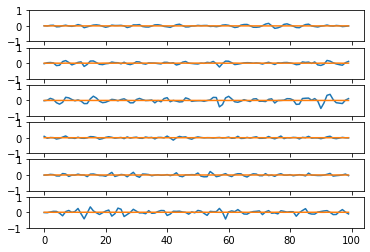

In [11]:
from matplotlib import pyplot as plt
import matplotlib.style as style

for i in range(0,6):
    plt.subplot(6,1,i+1)
    plt.plot(x_test_vae[0,i,:,0])
    # plt.plot(x_test_clean_vae[8000,i,:,0])
    # plt.plot(x_train_noise_vae[2345,i,:,0])
    plt.plot(x_pred_vae[0,i,:,0])
    plt.ylim(-1, 1)

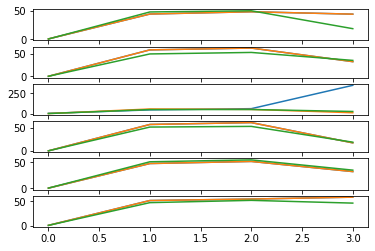

In [32]:
for i in range(0,6):
    plt.subplot(6,1,i+1)
    plt.plot(x_inv[9000,i,:,0])
    # plt.plot(x_train_noise_temp[9000,i,:,0])
    plt.plot(x_train_clean_temp[9000,i,:,0])
    plt.plot(x_pred[9000,i,:,0])

In [44]:
feat_test = prd.extract_feats(np.squeeze(x_train_noise[2345,:,:,0]))

IndexError: tuple index out of range

In [54]:
test = x_train_noise[2345:2347,:,:,:]

In [63]:
test_feat = prd.extract_feats(test)
test_res = np.transpose(test_feat.reshape((test.shape[0],4,-1)),(0,2,1))[...,np.newaxis]

In [64]:
test_1 = test_res[0,:,:,:]

# Denoising Supervised VAE Loop

In [9]:
acc_all, acc_noise, acc_clean, file_name = lp.run_loop(raw, params, sub_type, load=True, n_train='gaussflat', train_scale = 3, n_test='flat',test_scale=1, nn = 'sae', epochs=50)

Running sub 1, model 2
Running sub 2, model 2
Running sub 3, model 2
Running sub 4, model 2
Running sub 5, model 2
Running sub 6, model 2
Running sub 7, model 2
Running sub 8, model 2
Running sub 9, model 2
Running sub 10, model 2
Running sub 11, model 2
Running sub 12, model 2
Running sub 13, model 2
Running sub 14, model 2


In [5]:
acc_all, acc_clean, acc_noise, ave_all, ave_clean, ave_noise = lp.compile_acc(acc_all, acc_noise, acc_clean, file_name, test_scale=1)

In [8]:
results_file = 'models_2/svae_feat_dim_3_ep_50_gaussflat_3_AB'
test_scale = 1
with open(results_file + '_' + str(test_scale)  + '_results.p', 'rb') as f:
        acc_all2, acc_clean2, acc_noise2, ave_all2, ave_clean2, ave_noise2 = pickle.load(f)

# Plot Reconstruction

In [1]:
import sVAE_utils as svae
import process_data as prd

In [5]:
sub_type = 'AB'
n_train = 'flat'
train_scale = 0
n_test= 'flat'
test_scale = 0
feat_type = 'feat'
latent_dim = 3
epochs = 30
train_grp = 2
sub = 1
foldername = 'models' + '_' + str(train_grp)
filename = foldername + '/vae_clean' + n_train + '_' + str(train_scale) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + sub_type 
# filename = foldername + '/svae_' + feat_type + '_dim_' + str(latent_dim) + '_' + sub_type
with open(filename + str(sub) + '.p', 'rb') as f:
    # scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned, c_aligned, x_train, x_test, p_train, p_test = pickle.load(f)  
    scaler, vae_w, enc_w, dec_w, w, c, w_aligned, c_aligned, x_train, x_test, p_train, p_test = pickle.load(f)

In [6]:
# Get ground truth
y_train = p_train[:,4]
y_test = p_test[:,4]

# Add noise and index EMG data
x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub, n_train, train_scale)
x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub, n_test, test_scale)

# vae, encoder, decoder, clf = svae.build_svae_corrupt(latent_dim, y_train_clean.shape[1], input_type=feat_type)
vae, encoder, decoder = svae.build_vae_corrupt(latent_dim, input_type=feat_type)

vae.set_weights(vae_w)
encoder.set_weights(enc_w)
decoder.set_weights(dec_w)
# clf.set_weights(clf_w)

In [7]:
x_train_noise_temp = prd.extract_feats(x_train_noise).reshape((x_train_noise.shape[0],6,-1))[...,np.newaxis]
x_test_noise_temp = prd.extract_feats(x_test_noise).reshape((x_test_noise.shape[0],6,-1))[...,np.newaxis]
x_train_clean_temp = prd.extract_feats(x_train_clean).reshape((x_train_clean.shape[0],6,-1))[...,np.newaxis]
x_test_clean_temp = prd.extract_feats(x_test_clean).reshape((x_test_clean.shape[0],6,-1))[...,np.newaxis]

x_train_noise_vae = scaler.transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0],-1)).reshape(x_train_noise_temp.shape)
x_train_vae = scaler.transform(x_train_clean_temp.reshape(x_train_clean_temp.shape[0],-1)).reshape(x_train_clean_temp.shape)
x_test_vae = scaler.transform(x_test_noise_temp.reshape(x_test_noise_temp.shape[0],-1)).reshape(x_test_noise_temp.shape)
x_test_clean_vae = scaler.transform(x_test_clean_temp.reshape(x_test_clean_temp.shape[0],-1)).reshape(x_test_clean_temp.shape)
clean_size = int(np.size(x_test_clean,axis=0)/(np.size(x_test_clean,axis=1)+1))

In [12]:
x_recon_vae = svae.recon_vae(vae, x_train_vae[0:2,:,:,0:2])
# x_recon = scaler.inverse_transform(x_recon_vae.reshape(x_recon_vae.shape[0],-1)).reshape(x_recon_vae.shape)

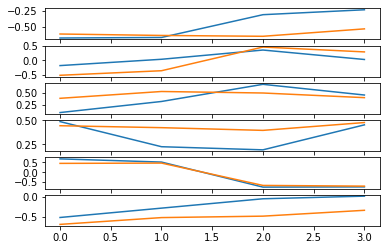

In [14]:
from matplotlib import pyplot as plt
import matplotlib.style as style

for i in range(0,6):
    plt.subplot(6,1,i+1)
    # plt.plot(x_test_clean_temp[1156,i,:,0])
    plt.plot(x_train_vae[1,i,:,0])
    plt.plot(x_recon_vae[1,i,:,0])

# Load and Plot NER

In [ ]:
# LOAD RESULTS FILE
sub_type = 'AB'
n_type = 'flat'
epochs = 30
n_scale = 5
test_scale = 1
train_grp = 2
latent_dim = 3
feat_type = 'feat'
foldername = 'models' + '_' + str(train_grp)
filename = foldername + '/sae_' + n_type + '_' + str(n_scale) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + sub_type + '_' + str(test_scale)
filename = foldername + '/svae_' + feat_type + '_dim_' + str(latent_dim) + '_' + sub_type
results_file = filename + '_results.p'

with open(results_file, 'rb') as f:
    acc_all, acc_clean, acc_noise, ave_all, ave_clean, ave_noise = pickle.load(f)  

In [ ]:
se = sem(acc_clean,axis=0)*100

In [ ]:
from scipy.stats import sem
from matplotlib import pyplot as plt
import matplotlib.style as style

style.use('default')
# plot_file = 'figures/' + foldername + '_svae_' + feat_type + '_dim_' + str(latent_dim) +'_' + sub_type

fontsize = 12
labels = ['Baseline LDA','Noisy LDA','Aligned LDA','VAE']
x1 = np.arange(len(labels))  # the label locations 

bar_width = 0.25
# Set position of bar on X axis
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

fig = plt.figure() 
ax = fig.add_axes([0,0,1,1])
acc_all_mean = np.mean(acc_all[:,[2,3,1,0]],axis=0)*100
acc_all_se = sem(acc_all[:,[2,3,1,0]],axis=0)*100
acc_clean_mean = np.mean(acc_clean[:,[2,3,1,0]],axis=0)*100
acc_clean_se = sem(acc_clean[:,[2,3,1,0]],axis=0)*100
acc_noise_mean = np.mean(acc_noise[:,[2,3,1,0]],axis=0)*100
acc_noise_se = sem(acc_noise[:,[2,3,1,0]],axis=0)*100

ax.bar(x1,acc_all_mean,width=bar_width,label='All',linewidth=1,yerr=acc_all_se,edgecolor='black')
ax.bar(x2,acc_clean_mean,width=bar_width,label='Clean',linewidth=1,yerr=acc_clean_se,edgecolor='black')
ax.bar(x3,acc_noise_mean,width=bar_width,label='Noisy',linewidth=1,yerr=acc_noise_se,edgecolor='black')

ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
ax.set_xticks(x2)
ax.set_xticklabels(labels)
# ax.errorbar(['VAE','Aligned','LDA','LDA Corrupt'],acc_all_mean,acc_all_se,fmt='none',ecolor='black')
plt.rcParams.update({'font.size': fontsize})
# plt.savefig(plot_file + '.svg',dpi=300)
# plt.box(on=None)
# for i, v in enumerate(temp):
#     ax.text(i-.24, v-8, "%.2f" % v, color='black',fontsize=18)

x = np.zeros([4,3])
x[0,:] = np.arange(3)  # the label locations

bar_width = 0.2
# Set position of bar on X axis
for i in range(0,3):
    x[i+1,:] = [xi + bar_width for xi in x[i,:]]
xmid = x[1]+x[2]


fig = plt.figure(figsize=(5,2.5))
ax = fig.add_axes([0,0,1,1])

for i in range(0,4):
    ax.bar(x[i,:],[acc_all_mean[i],acc_clean_mean[i],acc_noise_mean[i]],label=labels[i],width=bar_width,linewidth=.5,yerr=[acc_all_se[i],acc_clean_se[i],acc_noise_se[i]],edgecolor='white')

ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
ax.set_xticks([i/2 for i in np.add(x[1,:],x[2,:])])
ax.set_xticklabels(['Full','Clean','Corrupted'])
# ax.errorbar(['VAE','Aligned','LDA','LDA Corrupt'],acc_all_mean,acc_all_se,fmt='none',ecolor='black')
plt.rcParams.update({'font.size': fontsize})
# plt.savefig(plot_file + '_2.svg',dpi=300)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
temp = np.mean(acc_clean[:,:],axis=0)*100
se = sem(acc_clean,axis=0)*100
ax.bar(['VAE','Aligned','LDA','LDA Corrupt'],temp)
ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
ax.errorbar(['VAE','Aligned','LDA','LDA Corrupt'],temp,se,fmt='none',ecolor='black')
plt.rcParams.update({'font.size': fontsize})
# plt.box(on=None)
for i, v in enumerate(temp):
    ax.text(i-.24, v-8, "%.2f" % v, color='black',fontsize=18)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
temp = np.mean(acc_noise[:,:],axis=0)*100
se = sem(acc_noise,axis=0)*100
ax.bar(['VAE','Aligned','LDA','LDA Corrupt'],temp)
ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
ax.errorbar(['VAE','Aligned','LDA','LDA Corrupt'],temp,se,fmt='none',ecolor='black')
plt.rcParams.update({'font.size': fontsize})
# plt.box(on=None)
for i, v in enumerate(temp):
    ax.text(i-.24, v-8, "%.2f" % v, color='black',fontsize=18)

## Old loop

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sVAE_utils as svae
import process_data as prd
from lda import train_lda, predict, eval_lda
from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp

set_gpu()

In [ ]:
sub_type = 'AB'
## LOAD DATA
# Load raw EMG data
feat,params,daq = prd.load_train_data('train_data_raw_'+ sub_type + '.mat')
raw = prd.process_daq(daq,params)

if sub_type == 'AB':
    # Remove position 5
    rem_ind = params[:,5]!=5
    feat = feat[rem_ind,:]
    raw = raw[:,:,rem_ind]
    params = params[rem_ind,:]

    # Remove load 2
    rem_ind = params[:,3]!=5
    feat = feat[rem_ind,:]
    raw = raw[:,:,rem_ind]
    params = params[rem_ind,:]
    params[params[:,3]==6,3] = 5 

# Reshape data for CNN architecture
raw = raw[::2,:,:].transpose(2,1,0)
feat_sq = feat.reshape(feat.shape[0],6,10)

In [ ]:
# VAE hyperparameters
batch_size = 128
latent_dim = 3
epochs = 30
n_scale = 5
n_type = 'gauss'
feat_type = 'feat'
# data_in = norm_sub(feat_sq, params)

# initialize variable to collect accuracies
acc_all = np.zeros([np.max(params[:,0]),4])
acc_clean = np.zeros([np.max(params[:,0]),4])
acc_noise = np.zeros([np.max(params[:,0]),4])

# Loop through subjects
for sub in range(1,2):#np.max(params[:,0])+1):
    # Loop through training groups
    for train_grp in range(2,3):#np.max(params[:,3])+1):
        ind = (params[:,0] == sub) & (params[:,3] == train_grp)

        # Check if training data exists
        if np.sum(ind):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            # Set folder and file names
            foldername = 'models' + '_' + str(train_grp)
            if not os.path.exists(foldername):
                os.makedirs(foldername)
            filename = foldername + '/svae_' + n_type + '_' + str(n_scale) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + sub_type + str(sub)

            # Split training and testing data
            x_train, x_test, p_train, p_test = train_test_split(raw[ind,:,:], params[ind,:], test_size = 0.33, stratify=params[ind,4])

            # # Initialize scaler
            scaler = MinMaxScaler(feature_range=(-1,1))

            # Load saved data
            with open(filename + '.p', 'rb') as f:
                scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned, c_aligned, x_train, x_test, p_train, p_test = pickle.load(f)   
            
            # # Get ground truth
            y_train = p_train[:,4]
            y_test = p_test[:,4]

            # # Add noise and index EMG data
            x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub, n_type,n_scale)
            x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub, n_type,n_scale)

            x_train_noise_temp = prd.extract_feats(x_train_noise).reshape((x_train_noise.shape[0],6,-1))[...,np.newaxis]
            x_test_noise_temp = prd.extract_feats(x_test_noise).reshape((x_test_noise.shape[0],6,-1))[...,np.newaxis]
            x_train_clean_temp = prd.extract_feats(x_train_clean).reshape((x_train_clean.shape[0],6,-1))[...,np.newaxis]
            x_test_clean_temp = prd.extract_feats(x_test_clean).reshape((x_test_clean.shape[0],6,-1))[...,np.newaxis]
            clean_size = int(np.size(x_test_clean,axis=0)/(np.size(x_test_clean,axis=1)+1))

            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            x_train_noise_vae = scaler.fit_transform(x_train_noise_temp.reshape(x_train_noise_temp.shape[0],-1)).reshape(x_train_noise_temp.shape)
            x_train_vae = scaler.transform(x_train_clean_temp.reshape(x_train_clean_temp.shape[0],-1)).reshape(x_train_clean_temp.shape)
            x_test_vae = scaler.transform(x_test_noise_temp.reshape(x_test_noise_temp.shape[0],-1)).reshape(x_test_noise_temp.shape)

            # # Build VAE
            vae, encoder, decoder,clf = svae.build_svae_corrupt(latent_dim, y_train_clean.shape[1], input_type=feat_type)
            # vae, encoder, decoder = svae.build_vae_corrupt(latent_dim, input_type=feat_type)

            # # Fit VAE and get weights
            # vae.fit(x_train_noise_vae, [x_train_vae,y_train_clean],epochs=epochs,batch_size=batch_size)
            # vae.fit(x_train_noise_vae, x_train_vae, epochs=epochs, batch_size = batch_size)
            
            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()
            clf_w = clf.get_weights()

            # Load and set weights             
            vae.set_weights(vae_w)
            encoder.set_weights(enc_w)
            decoder.set_weights(dec_w)
            clf.set_weights(clf_w)

            # Test full VAE
            y_pred, acc_all[sub-1,0] = svae.eval_vae(vae, x_test_vae, y_test_clean)
            _, acc_noise[sub-1,0] = svae.eval_vae(vae,x_test_vae[clean_size:,:,:,:], y_test_clean[clean_size:,:])
            _, acc_clean[sub-1,0] = svae.eval_vae(vae,x_test_vae[:clean_size,:,:,:], y_test_clean[:clean_size,:])

            # Test encoder-LDA combo
            _, _, x_train_aligned = encoder.predict(x_train_noise_vae)
            _,_, x_test_aligned = encoder.predict(x_test_vae)
            y_train_aligned = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
            y_test_aligned = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)
            acc_all[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)
            acc_noise[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned[clean_size:,:], y_test_aligned[clean_size:,:])
            acc_clean[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned[:clean_size,:], y_test_aligned[:clean_size,:])

            # Baseline LDA
            x_train_lda = prd.extract_feats(x_train)
            x_test_lda = prd.extract_feats(x_test_noise)
            # x_test_lda = x_test_noise.reshape((x_test_noise.shape[0], x_test_noise.shape[1]*x_test_noise.shape[2]))
            y_train_lda = y_train[...,np.newaxis] - 1
            # y_test_lda = y_train[...,np.newaxis] - 1
            y_test_lda = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda,y_train_lda)
            acc_all[sub-1,2] = eval_lda(w, c, x_test_lda, y_test_lda)
            acc_noise[sub-1,2] = eval_lda(w, c, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
            acc_clean[sub-1,2] = eval_lda(w, c, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])

            # LDA trained with corrupted data
            x_train_lda2 = prd.extract_feats(x_train_noise)
            # x_train_lda2 = x_train_noise.reshape((x_train_noise.shape[0], x_train_noise.shape[1]*x_train_noise.shape[2]))
            y_train_lda2 = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda2,y_train_lda2)
            acc_all[sub-1,3] = eval_lda(w, c, x_test_lda, y_test_lda)
            acc_noise[sub-1,3] = eval_lda(w, c, x_test_lda[clean_size:,:], y_test_lda[clean_size:,:])
            acc_clean[sub-1,3] = eval_lda(w, c, x_test_lda[:clean_size,:], y_test_lda[:clean_size,:])

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned, x_train, x_test, p_train, p_test],f)

In [ ]:
acc_all = acc_all[~np.all(acc_all == 0, axis=1)]
acc_clean = acc_clean[~np.all(acc_clean == 0, axis=1)]
acc_noise = acc_noise[~np.all(acc_noise == 0, axis=1)]

ave_all = np.mean(acc_all,axis=0)
ave_clean = np.mean(acc_clean,axis=0)
ave_noise = np.mean(acc_noise,axis=0)

# results_file = foldername + '/svae_' + feat_type + '_dim_' + str(latent_dim) +'_' + sub_type
results_file = foldername + '/svae_' + n_type + '_' + str(n_scale) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_' + sub_type + str(sub)

# Pickle variables
with open(results_file  + '_results.p', 'wb') as f:
    pickle.dump([acc_all, acc_clean, acc_noise, ave_all, ave_clean, ave_noise],f)

# Denoising VAE Loop

In [ ]:
test = x_train_noise.reshape((x_train_noise.shape[0],6,-1))[...,np.newaxis]

In [ ]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 5
epochs = 30
feat_type = 'raw'
# data_in = norm_sub(feat_sq, params)

# initialize variable to collect accuracies
acc_all = np.zeros([np.max(params[:,0]),4])

# Loop through subjects
for sub in range(1,np.max(params[:,0])+1):
    # Loop through training groups
    for train_grp in range(2,3):#np.max(params[:,3])+1):
        ind = (params[:,0] == sub) & (params[:,3] == train_grp)

        # Check if training data exists
        if np.sum(ind):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            # Set folder and file names
            foldername = 'models' + '_' + str(train_grp)
            if not os.path.exists(foldername):
                os.makedirs(foldername)
            filename = foldername + '/denoise_vae' + feat_type + '_' + sub_type + str(sub)

            # Split training and testing data
            x_train, x_test, p_train, p_test = train_test_split(raw[ind,:,:], params[ind,:], test_size = 0.33, stratify=params[ind,4])
            y_train = p_train[:,4]
            y_test = p_test[:,4]

            # Add noise and index EMG data
            x_train_noise, x_train_clean, y_train_clean = prd.add_noise(x_train, p_train, sub)
            x_test_noise, x_test_clean, y_test_clean = prd.add_noise(x_test, p_test, sub)

            # x_train_noise = extract_feats(x_train_noise)
            # x_test_noise = extract_feats(x_test_noise)
            # x_train_clean = extract_feats(x_train_clean)
            # x_test_clean = extract_feats(x_test_clean)

            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            scaler = MinMaxScaler(feature_range=(-1,1))
            x_train_noise_vae = scaler.fit_transform(x_train_noise.reshape(x_train_noise.shape[0],-1)).reshape(x_train_noise.shape)
            x_train_vae = scaler.transform(x_train_clean.reshape(x_train_clean.shape[0],-1)).reshape(x_train_clean.shape)
            x_test_vae = scaler.transform(x_test_noise.reshape(x_test_noise.shape[0],-1)).reshape(x_test_noise.shape)

            # Build VAE
            vae, encoder, decoder = svae.build_vae_corrupt(latent_dim, input_type=feat_type)

            # Fit VAE and get weights
            vae.fit(x_train_noise_vae, x_train_vae,epochs=epochs,batch_size=batch_size)
            
            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()

            # Load and set weights 
            # with open(filename + '.p', 'rb') as f:
            #     scaler, vae_w, enc_w, dec_w, w, c, w_aligned,c_aligned, w_recon, c_recon = pickle.load(f)               
            # vae.set_weights(vae_w)
            # encoder.set_weights(enc_w)
            # decoder.set_weights(dec_w)

            # Test VAE-LDA combo
            x_train_recon = prd.extract_feats(vae.predict(x=x_train_noise_vae))
            x_test_recon = prd.extract_feats(vae.predict(x=x_test_vae))
            y_train_recon = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
            y_test_recon = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
            w_recon, c_recon = train_lda(x_train_recon,y_train_recon)
            acc_all[sub-1,0] = eval_lda(w_recon, c_recon, x_test_recon, y_test_recon)

            # Test encoder-LDA combo
            _, _, x_train_aligned = encoder.predict(x_train_noise_vae)
            _,_, x_test_aligned = encoder.predict(x_test_vae)
            y_train_aligned = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
            y_test_aligned = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)
            acc_all[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)

            # Baseline LDA
            x_train_lda = prd.extract_feats(x_train)
            x_test_lda = prd.extract_feats(x_test_noise)
            y_train_lda = y_train[...,np.newaxis] - 1
            y_test_lda = np.argmax(y_test_clean, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda,y_train_lda)
            acc_all[sub-1,2] = eval_lda(w, c, x_test_lda, y_test_lda)

            # LDA trained with corrupted data
            x_train_lda2 = prd.extract_feats(x_train_noise_vae)
            x_test_lda2 = prd.extract_feats(x_test_vae)
            y_train_lda2 = np.argmax(y_train_clean, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda2,y_train_lda2)
            acc_all[sub-1,3] = eval_lda(w, c, x_test_lda2, y_test_lda)

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, w, c, w_aligned,c_aligned, w_recon, c_recon],f)

In [ ]:
from scipy.stats import sem
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
temp = np.mean(acc_all[:,:],axis=0)*100
ax.bar(['VAE','Aligned','LDA','LDA Corrupt'],temp)
ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
plt.box(on=None)
for i, v in enumerate(temp):
    ax.text(i-.15, v+.4, str(round(v,2)), color='black',fontsize=12)

# Reconstruction

In [ ]:
train_grp = 2
# sub = 1
feat_type = 'feat'
foldername = 'models' + '_' + str(train_grp)
filename = foldername + '/svae' + feat_type + '_' + sub_type + str(sub)
with open(filename + '.p', 'rb') as f:
    # scaler, vae_w, enc_w, dec_w, w, c, w_aligned,c_aligned, w_recon, c_recon = pickle.load(f)
    scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned = pickle.load(f)

vae, encoder, decoder,clf = svae.build_svae_corrupt(latent_dim, y_train_clean.shape[1], input_type=feat_type)
vae.set_weights(vae_w)
encoder.set_weights(enc_w)
decoder.set_weights(dec_w)
clf.set_weights(clf_w)
x_noise = scaler.transform(x_train_noise.reshape(x_train_noise.shape[0],-1)).reshape(x_train_noise.shape)
x_clean = scaler.transform(x_train_clean.reshape(x_train_clean.shape[0],-1)).reshape(x_train_clean.shape)
x_t_noise = scaler.transform(x_test_noise.reshape(x_test_noise.shape[0],-1)).reshape(x_test_noise.shape)
x_t_clean = scaler.transform(x_test_clean.reshape(x_test_clean.shape[0],-1)).reshape(x_test_clean.shape)
recon = vae.predict(x_t_noise)[0]

In [ ]:
i +=1
while (np.sum(np.abs(x_t_noise[i,:,:] - x_t_clean[i,:,:])<1e-7) == 24) | (np.argmax(y_train_clean[i,:]) == 0):    
    i+=1
i 


In [ ]:
test3 = np.squeeze(np.abs(x_t_noise[i,:,:] - x_t_clean[i,:,:]))

In [ ]:
test1 = np.squeeze(x_t_clean[i,:,:])
test2 = np.squeeze(x_t_noise[i,:,:])

In [ ]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x_test_clean[i,ch,:])
    plt.plot(x_test_noise[i,ch,:])
    # plt.plot(x_noise[i,ch,:])
    # plt.ylim(-1,1)


# plt.subplot(x_test_vae[0,0,:])

In [ ]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x_t_clean[i,ch,:])
    plt.plot(x_t_noise[i,ch,:])
    plt.ylim(-1,1)


In [ ]:
# recon_inv = scaler.inverse_transform(recon.reshape(recon.shape[0],-1)).reshape(recon.shape)
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x_t_clean[i,ch,:])
    plt.plot(recon[i,ch,:])
    # plt.plot(x_t_noise[i,ch,:])
    plt.ylim(-1,1)

In [ ]:
bool = recon[3500,1,:] == x_1[3500,1,:]

# Transfer Learning

In [ ]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 25
feat_type = 'feat'
# data_in = norm_sub(feat_sq, params)

loo = np.ones([np.max(params[:,0]),1])
# loo[1,0] = 1

for sub in range(1,np.max(params[:,0])+1):
    for train_grp in range(3,4):#np.max(params[:,3])+1):
        foldername = 'models' + '_' + str(train_grp)

        if not os.path.exists(foldername):
            os.makedirs(foldername)


        filename = foldername + '/vae_grp4_lin_' + feat_type + '_AB' + str(sub)

        # Index EMG data
        x_train, y_train = sub_split(data_in,params,sub,train_grp)
        x_train_loo, y_train_loo = sub_split_loo(data_in,params,sub,train_grp)
        x_train, y_train = sub_split_stat(data_in,params,sub,train_grp)

        # Check if training data exists
        if (type(x_train) == np.ndarray) & (type(x_train_loo) == np.ndarray):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            
            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            scaler = MinMaxScaler(feature_range=(-1,1))
            x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)

            # Build VAE
            vae, encoder, decoder, clf = build_vae(latent_dim, input_type=feat_type)

            # # Fit and save VAE
            vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()
            clf_w = clf.get_weights()

            ## LEAVE ONE OUT SUPERVISED VAE
            if loo[sub-1,0]:
                # Scale data
                scaler_loo = MinMaxScaler(feature_range=(-1,1))
                x_train_loo = scaler_loo.fit_transform(x_train_loo.reshape(x_train_loo.shape[0],-1)).reshape(x_train_loo.shape)

                # Build VAE
                vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)

                # # Fit and save VAE
                vae_loo.fit(x_train_loo, {'clf': y_train_loo},epochs=epochs,batch_size=batch_size)
                vae_loo_w = vae_loo.get_weights()
                enc_loo_w = encoder_loo.get_weights()
                dec_loo_w = decoder_loo.get_weights()
                clf_loo_w = clf_loo.get_weights()

                loo[sub-1,0] = 0
            else:
                loo_file = 'models_3/vae_grp4_lin_' + feat_type + '_AB2'# + str(sub)
                with open(loo_file + '.p', 'rb') as f:
                    _, _, _, _, _, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, _, _, _, _, _, _, _, _, _, _ = pickle.load(f)

            ## BASELINE LDA
            # Train LDA classifier
            x_train_lda, y_train_lda = sub_split(feat, params, sub, train_grp)
            x_train_lda, y_train_lda = sub_split_stat(feat, params, sub, train_grp)
            w,c = train_lda(x_train_lda,y_train_lda)

            ## SUPERVISED VAE ALIGNED
            # Align
            # with open(filename + '.p', 'rb') as f:
            #     scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, w, c, w_aligned, c_aligned = pickle.load(f)

            # encoder.set_weights(enc_w)
            _, _, x_train_aligned = encoder.predict(x_train)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)

            ## PNN TEST
            vae_t, encoder_t, decoder_t, clf_t = build_pnn(vae_loo_w, latent_dim, input_type=feat_type)
            vae_t.fit(x_train, {'t_clf': y_train}, epochs=25,batch_size=batch_size)
            vae_t_w = vae_t.get_weights()
            enc_t_w = encoder_t.get_weights()
            dec_t_w = decoder_t.get_weights()
            clf_t_w = clf_t.get_weights()

            ## PNN ALIGNED
            _, _, x_train_aligned = encoder_t.predict(x_train)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            w_t, c_t = train_lda(x_train_aligned,y_train_aligned)

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, vae_t_w, enc_t_w, dec_t_w, clf_t_w, w, c, w_aligned,c_aligned, w_t, c_t],f)

In [ ]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 50

feat_type = 'feat'
data_in = feat_sq
# data_in = norm_sub(feat_sq,params)

sub_ave = np.zeros([6,1])
for sub in range(1,np.max(params[:,0])+1):
    for train_grp in range(3,4):#np.max(params[:,3])+1):
        foldername = 'models' + '_' + str(train_grp)
        filename = foldername + '/vae_grp4_lin_' + feat_type + '_AB' + str(sub)

        # Check if training data exists
        if os.path.exists(filename + '.p'):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            with open(filename + '.p', 'rb') as f:
                scaler, vae_w, enc_w, dec_w, clf_w, scaler_loo, vae_loo_w, enc_loo_w, dec_loo_w, clf_loo_w, vae_t_w, enc_t_w, dec_t_w, clf_t_w, w, c, w_aligned, c_aligned, w_t, c_t = pickle.load(f)
            # Build VAE
            vae, encoder, decoder, clf = build_vae(latent_dim, input_type=feat_type)
            vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)
            vae_t, encoder_t, decoder_t, clf_t = build_pnn(vae_loo_w, latent_dim, input_type=feat_type)

            ave_all = np.zeros([6,1])
            ave_count = 0
            for test_grp in range(3,4):#np.max(params[:,3])+1):
                # Index and scale test data
                x_test_raw, y_test = sub_split(data_in, params, sub, test_grp)
                if type(x_test_raw) == np.ndarray:
                    x_test = scaler.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)
                    x_test_loo = scaler_loo.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)

                    # Evaluate VAE predictions
                    vae.set_weights(vae_w)
                    y_pred, acc_vae = eval_vae(vae, x_test, y_test)

                    # Evaluate LDA predictions
                    x_test_lda, y_test_lda = sub_split(feat, params, sub, test_grp)
                    acc_lda = eval_lda(w, c, x_test_lda, y_test_lda)

                    # Evaluate LDA aligned predictions
                    encoder.set_weights(enc_w)
                    _, _, x_test_aligned = encoder.predict(x_test)
                    y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
                    acc_lda_aligned = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)

                    # Evaluate VAE-LOO predictions
                    vae_loo.set_weights(vae_loo_w)
                    y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_test)

                    # Evaluate PNN predictions
                    vae_t.set_weights(vae_t_w)
                    y_pred, acc_vae_t = eval_vae(vae_t, x_test, y_test)

                    # Evaluate PNN-LDA aligned predictions
                    encoder_t.set_weights(enc_t_w)
                    _, _, x_test_aligned = encoder_t.predict(x_test)
                    y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
                    acc_pnn_aligned = eval_lda(w_t, c_t, x_test_aligned, y_test_aligned)
                    
                    if (test_grp == 4) or (test_grp == 2):
                        ave_all += np.array([acc_vae, acc_lda, acc_lda_aligned, acc_vae_loo, acc_vae_t, acc_pnn_aligned]).reshape(6,1)
                        ave_count += 1
                    # print(ave_all)
                    print(str(test_grp) + ': vae - ' + "%.2f" % acc_vae + ', lda - ' + "%.2f" % acc_lda + ', lda aligned - ' 
                    + "%.2f" % acc_lda_aligned + ', vae loo - ' + "%.2f" % acc_vae_loo + ', pnn - ' + "%.2f" % acc_vae_t + ', pnn aligned - ' + "%.2f" % acc_pnn_aligned)
                    # print(str(test_grp) + ': lda - ' + "%.2f" % acc_lda + ', pnn - ' + "%.2f" % acc_vae_t + ', pnn aligned - ' + "%.2f" % acc_pnn_aligned)
            ave_all /= ave_count
            sub_ave += ave_all
sub_ave /=8
print(sub_ave)

In [ ]:
sub_ave*= 8
sub_ave/= 13
print(sub_ave)

In [ ]:
sub = 2
train_grp = 4
data_in = feat_sq
feat_type = 'feat'
latent_dim = 10
batch_size = 128

x_train_loo, y_train_loo = sub_split_loo(data_in,params,sub,train_grp)
scaler_loo = MinMaxScaler(feature_range=(-1,1))
x_train_loo = scaler_loo.fit_transform(x_train_loo.reshape(x_train_loo.shape[0],-1)).reshape(x_train_loo.shape)

# Build VAE
vae_loo, encoder_loo, decoder_loo, clf_loo = build_vae(latent_dim, input_type=feat_type)

# # Fit and save VAE
vae_loo.fit(x_train_loo, {'clf': y_train_loo},epochs=100,batch_size=batch_size, validation_split = .1)
vae_loo_w = vae_loo.get_weights()
enc_loo_w = encoder_loo.get_weights()
dec_loo_w = decoder_loo.get_weights()
clf_loo_w = clf_loo.get_weights()

x_test_raw, y_test = sub_split(data_in, params, sub, train_grp)
x_test_loo = scaler_loo.transform(x_test_raw.reshape(x_test_raw.shape[0],-1)).reshape(x_test_raw.shape)
y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_train_loo)

In [ ]:
y_pred, acc_vae_loo = eval_vae(vae_loo, x_test_loo, y_test)
acc_vae_loo

In [ ]:
ave_all = np.zeros([6,1])
ave_all += np.array([1,2,3,4,5,6]).reshape(6,1)

In [ ]:
sub_ave*=14
sub_ave/=13
print()

In [ ]:
print(sub_ave)

In [ ]:
vae, encoder, decoder, clf = build_vae(12, input_type='feat')


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(vae, to_file='vae.png', show_shapes=True)


# Segment

In [ ]:
## INITIALIZE VARIABLES ##
# Data variables
sub = 14
train_grp = 2
test_grp = 3

# VAE hyperparameters
batch_size = 64
latent_dim = 10
epochs = 10
filename = 'vae_raw.h5'

In [ ]:
out, orig, sub_params = add_noise(raw,params,1)

In [ ]:
# Index EMG data
x_train, y_train, x_test, y_test = sub_train_test(raw,params,sub,train_grp,test_grp)

# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

# Build VAE
vae, encoder, decoder, clf = build_vae(latent_dim, input_type='raw')

# Fit and save VAE
vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
vae.save_weights(filename)

In [ ]:
# Index and scale test data
x_test, y_test = sub_split(raw, params, sub, test_grp)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

# Evaluate VAE predictions
y_pred, acc = eval_vae(vae, x_test, y_test)
print(acc)

In [ ]:
# Train LDA classifier
x_train_lda, y_train_lda, x_test_lda, y_test_lda = sub_train_test(feat, params, sub, train_grp, test_grp)
w,c = train_lda(x_train_lda,y_train_lda)

In [ ]:
# Evaluate LDA predictions
x_test_lda, y_test_lda = sub_split(feat, params, sub, test_grp)
out = predict(x_test_lda,w,c)
np.sum(out.reshape(y_test_lda.shape) == y_test_lda)/y_test_lda.shape[0]